Implementation of Tigramite's JCPCMI Code

In [2]:
# Imports
import numpy as np
from numpy.random import SeedSequence
from matplotlib import pyplot as plt
import pandas as pd

import tigramite
from tigramite.toymodels import structural_causal_processes as toys
from tigramite.toymodels.context_model import ContextModel
from tigramite.jpcmciplus import JPCMCIplus
from tigramite.independence_tests.parcorr_mult import ParCorrMult
from tigramite.independence_tests.regressionCI import RegressionCI
import tigramite.data_processing as pp
import tigramite.plotting as tp

In [ ]:
pooled_data = pd.read_csv("housing_data.csv")
#print(housing_data.head())
print(pooled_data.isna().any().any())

datasets = []
for name, group in pooled_data.groupby("country"):
    #print(f"Group {name}:")
    #print(group)
    datasets.append(group)

time_range = len(datasets[0])
dummy_data_time = np.identity(time_range)
print("Time range:", time_range)
nb_domains = len(datasets)

system_indices = [0, 1,2,3,4]
# decide which context variables should be latent, and which are observed
observed_indices_time = [5]
latent_indices_time = []

observed_indices_space = [6]
latent_indices_space = []

observed_indices = system_indices + observed_indices_time + observed_indices_space

data_dict = {}
for i in range(nb_domains):
    dummy_data_space = np.zeros((time_range, nb_domains))
    dummy_data_space[:, i] = 1.
    subset = datasets[i][["hpnom", "ltrate", "realgdp", "cons", "tmort", "year"]]
    country = np.ones((time_range, 1))*i
    arr = subset.to_numpy()
    data_dict[i] = np.hstack((arr, country, dummy_data_time, dummy_data_space))

node_classification = {
    0: "system",
    1: "system",
    2: "system",
    3: "system",
    4: "system",
    5: "time_context",
    6: "space_context"
}

nb_observed_context_nodes = len(observed_indices_time) + len(observed_indices_space)
N = len(system_indices)

process_vars = system_indices
observed_temporal_context_nodes = list(range(N, N + len(observed_indices_time)))
observed_spatial_context_nodes = list(range(N + len(observed_indices_time), 
                                            N + len(observed_indices_time) + len(observed_indices_space)))
time_dummy_index = N + nb_observed_context_nodes
space_dummy_index = N + nb_observed_context_nodes + 1
time_dummy = list(range(time_dummy_index, time_dummy_index + time_range))
space_dummy = list(range(time_dummy_index + time_range, time_dummy_index + time_range + nb_domains))

vector_vars = {i: [(i, 0)] for i in process_vars + observed_temporal_context_nodes + observed_spatial_context_nodes}
vector_vars[time_dummy_index] = [(i, 0) for i in time_dummy]
vector_vars[space_dummy_index] = [(i, 0) for i in space_dummy]

sys_var_names = ['$X_%s$' % str(i) for i in process_vars]
context_var_names = ['t-$C_%s$' % str(i) for i in observed_indices_time] + ['s-$C_%s$' % str(i) for i in observed_indices_space]
var_names = sys_var_names + context_var_names + ['t-dummy', 's-dummy']

dataframe = pp.DataFrame(
    data=data_dict,
    vector_vars = vector_vars,
    analysis_mode = 'multiple',
    var_names = var_names
    )



False
Time range: 55


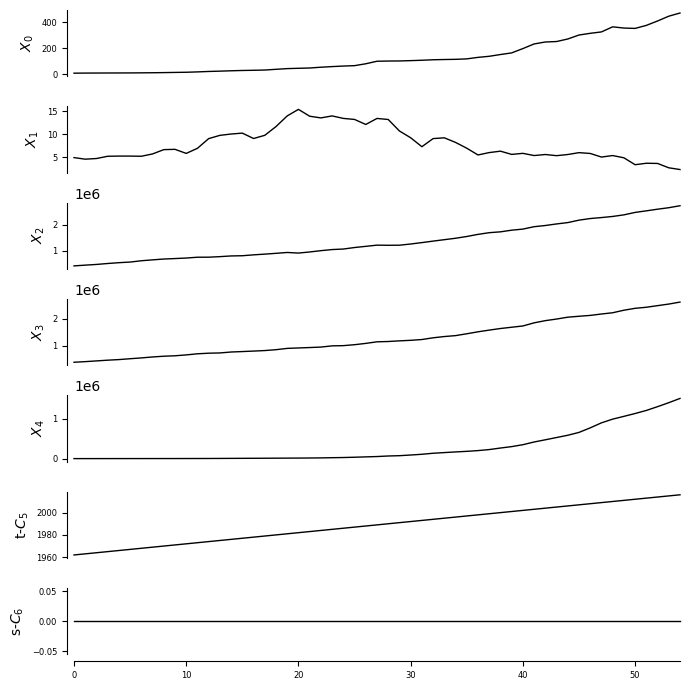

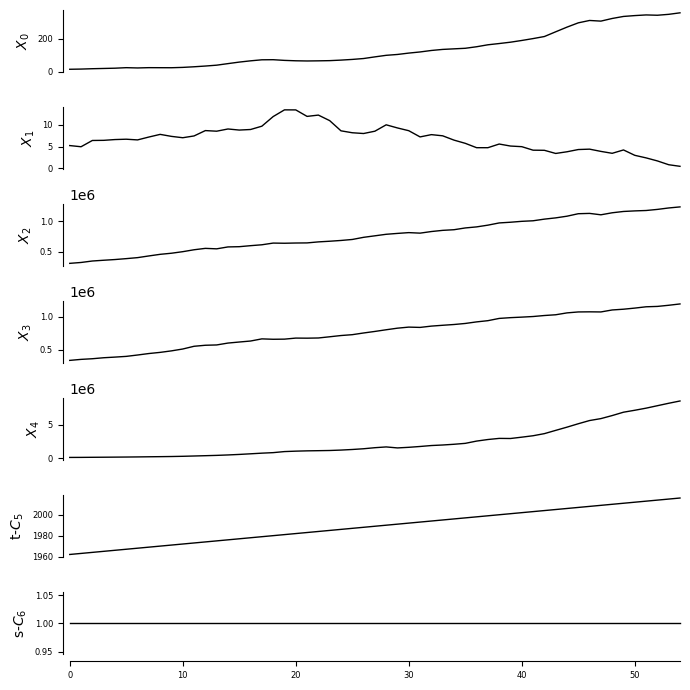

In [11]:
selected_variables=process_vars+observed_temporal_context_nodes+observed_spatial_context_nodes

for dataset in [0,1]:
    tp.plot_timeseries(selected_dataset = dataset, 
                       dataframe = dataframe, 
                       figsize=(7, 7), 
                       selected_variables=selected_variables)
    plt.show()

In [14]:
# Categorize all the nodes into system, context, or dummy
node_classification_jpcmci = {i: node_classification[var] for i, var in enumerate(observed_indices)}
node_classification_jpcmci.update({time_dummy_index : "time_dummy", space_dummy_index : "space_dummy"})

# Create a J-PCMCI+ object, passing the dataframe and (conditional)
# independence test objects, as well as the observed temporal and spatial context nodes 
# and the indices of the dummies.
jpcmciplus = JPCMCIplus(dataframe=dataframe,
                          cond_ind_test=ParCorrMult(significance='analytic'), 
                          node_classification=node_classification_jpcmci,
                          verbosity=1,)

# Define the analysis parameters.
tau_max = 2
pc_alpha = 0.01

# Run J-PCMCI+
results = jpcmciplus.run_jpcmciplus(tau_min=0, 
                              tau_max=tau_max, 
                              pc_alpha=pc_alpha)


##
## J-PCMCI+ Step 1: Selecting lagged conditioning sets
##

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
link_assumptions = {0: {(0, -1): '-?>', (0, -2): '-?>', (1, 0): 'o?o', (1, -1): '-?>', (1, -2): '-?>', (2, 0): 'o?o', (2, -1): '-?>', (2, -2): '-?>', (3, 0): 'o?o', (3, -1): '-?>', (3, -2): '-?>', (4, 0): 'o?o', (4, -1): '-?>', (4, -2): '-?>', (5, 0): '-?>', (5, -1): '-?>', (5, -2): '-?>', (6, 0): '-?>', (7, 0): '-?>', (8, 0): '-?>'}, 1: {(0, 0): 'o?o', (0, -1): '-?>', (0, -2): '-?>', (1, -1): '-?>', (1, -2): '-?>', (2, 0): 'o?o', (2, -1): '-?>', (2, -2): '-?>', (3, 0): 'o?o', (3, -1): '-?>', (3, -2): '-?>', (4, 0): 'o?o', (4, -1): '-?>', (4, -2): '-?>', (5, 0): '-?>', (5, -1): '-?>', (5, -2): '-?>', (6, 0): '-?>', (7, 0): '-?>', (8, 0): '-?>'}, 2: {(0, 0): 'o?o', (0, -1): '-?>', (0, -2): '-?>', (1, 0): 'o?o', (1, -1): '-?>', (1, -2): '-?>', (2, -1): '-?>', (2, -2): '-?>', (3, 0): 'o?o', (3, -1): '-?>', (3, -2): '-?>', (4, 0): 'o?o', (4, -1): '-?>',

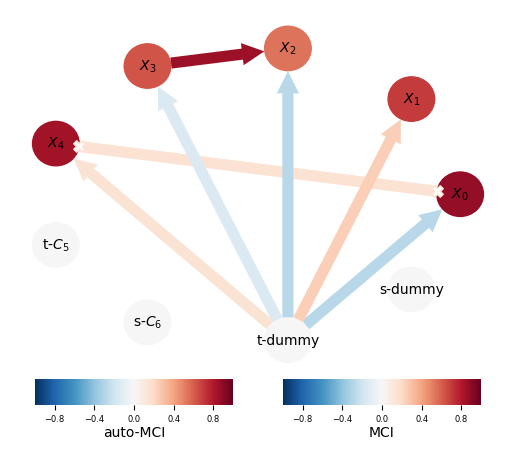

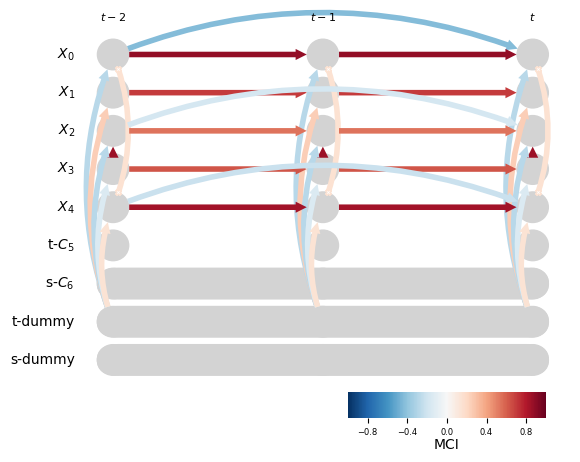

In [15]:
tp.plot_graph(results['graph'], val_matrix=results['val_matrix'], var_names=var_names)
tp.plot_time_series_graph(results['graph'], val_matrix = results['val_matrix'], 
              node_classification = node_classification_jpcmci, var_names=var_names)
plt.show()

Regression instead of ParrCorr

In [17]:
# Now we set up the dummy and dataframe that are suitable for RegressionCI, RegressionCI does the one-hot-encoding under the hood: 
dummy_data_time_regr = np.linspace(0,time_range,time_range, endpoint=False).reshape((time_range,1))

data_dict_regr = {}
for i in range(nb_domains):
    dummy_data_space_regr = np.array([i for j in range(time_range)]).reshape((time_range,1))
    subset = datasets[i][["hpnom", "ltrate", "realgdp", "cons", "tmort", "year"]]
    country = np.ones((time_range, 1))*i
    arr = subset.to_numpy()
    data_dict_regr[i] = np.hstack((arr, country, dummy_data_time_regr, dummy_data_space_regr))

# We also need to specify the data_type for RegressionCI, 0 is continuous and 1 discrete data
data_type =  np.zeros((15, time_range, 9), dtype='int')
data_type[:, :, 5] = 1 # time context
data_type[:, :, 6] = 1 # space context
data_type[:, :, time_dummy_index:] = 1 # dummies

dataframe_regr = pp.DataFrame(
    data=data_dict_regr,
    analysis_mode = 'multiple',
    data_type=data_type,
    var_names = var_names
    )

In [20]:
# only plot system variables and observed context variables
selected_variables=process_vars+observed_temporal_context_nodes+observed_spatial_context_nodes

# for dataset in [0,1]:
#     tp.plot_timeseries(selected_dataset = dataset, 
#                        dataframe = dataframe, 
#                        figsize=(7, 7), 
#                        selected_variables=selected_variables)
#     plt.show()

In [21]:

jpcmciplus_regr = JPCMCIplus(dataframe=dataframe_regr,
                          cond_ind_test=RegressionCI(significance='analytic'),
                          node_classification=node_classification_jpcmci,
                          verbosity=2,)

# Define the analysis parameters.
tau_max = 2
pc_alpha = 0.01

# Run J-PCMCI+
results_regr = jpcmciplus_regr.run_jpcmciplus(tau_min=0, 
                              tau_max=tau_max, 
                              pc_alpha=pc_alpha)


##
## J-PCMCI+ Step 1: Selecting lagged conditioning sets
##

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
link_assumptions = {0: {(0, -1): '-?>', (0, -2): '-?>', (1, 0): 'o?o', (1, -1): '-?>', (1, -2): '-?>', (2, 0): 'o?o', (2, -1): '-?>', (2, -2): '-?>', (3, 0): 'o?o', (3, -1): '-?>', (3, -2): '-?>', (4, 0): 'o?o', (4, -1): '-?>', (4, -2): '-?>', (5, 0): '-?>', (5, -1): '-?>', (5, -2): '-?>', (6, 0): '-?>', (7, 0): '-?>', (8, 0): '-?>'}, 1: {(0, 0): 'o?o', (0, -1): '-?>', (0, -2): '-?>', (1, -1): '-?>', (1, -2): '-?>', (2, 0): 'o?o', (2, -1): '-?>', (2, -2): '-?>', (3, 0): 'o?o', (3, -1): '-?>', (3, -2): '-?>', (4, 0): 'o?o', (4, -1): '-?>', (4, -2): '-?>', (5, 0): '-?>', (5, -1): '-?>', (5, -2): '-?>', (6, 0): '-?>', (7, 0): '-?>', (8, 0): '-?>'}, 2: {(0, 0): 'o?o', (0, -1): '-?>', (0, -2): '-?>', (1, 0): 'o?o', (1, -1): '-?>', (1, -2): '-?>', (2, -1): '-?>', (2, -2): '-?>', (3, 0): 'o?o', (3, -1): '-?>', (3, -2): '-?>', (4, 0): 'o?o', (4, -1): '-?>',

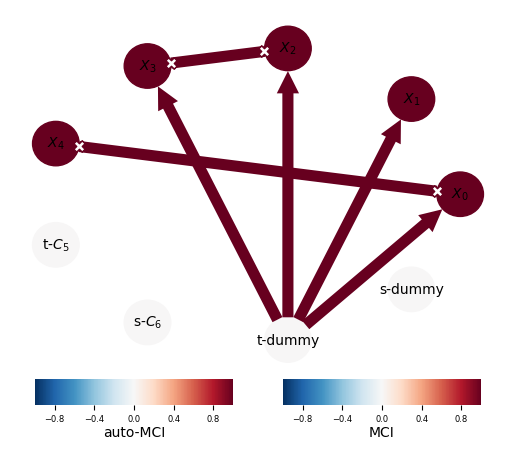

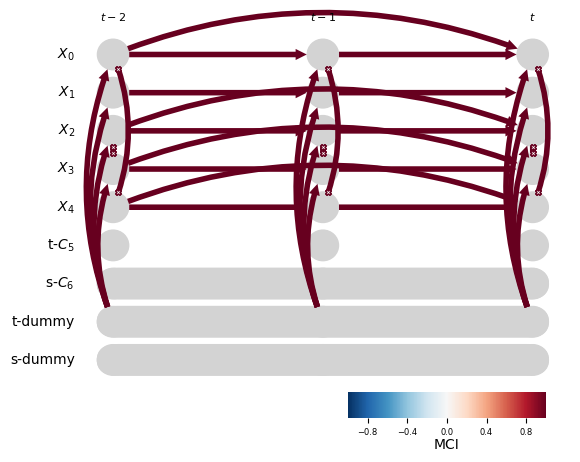

In [22]:
tp.plot_graph(results_regr['graph'], val_matrix=results_regr['val_matrix'], var_names=var_names)
tp.plot_time_series_graph(results_regr['graph'], val_matrix = results_regr['val_matrix'], 
              node_classification = node_classification_jpcmci, var_names=var_names)
plt.show()